# DiploDatos 2020 - Coronavirus en Argentina

El dataset se encuetra en:

https://github.com/lucia15/Datos-Covid19-Argentina

In [1]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Práctico Introducción al Machine Learning

**Consigna:**

Proponer un modelo de Aprendizaje Automático para estos datos. 

Para ello deberan explorar y probar varios modelos, buscando las configuraciones que mejores resultados den. Tener en cuenta:

* Elección de la variable objetivo y features
* Selección de un modelo
* Ajuste de hiperparámetros 
* Evaluación

Veamos unos sencillos (e incompletos) **ejemplos**.

### Carga de datos

In [2]:
# Importamos librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19.csv'

data = pd.read_csv(url, error_bad_lines=False)

**Variable objetivo: 'casos_nuevos'**

Puesto que muchas de las variables presentes en el dataset son **series temporales**, es importante tener en cuenta que para aplicar modelos de aprendizaje supervisado, es necesario realizar algunas adaptaciones previamente.

El siguiente método se conoce como **sliding window**.

In [4]:
df = pd.DataFrame()

df['t']   = data['casos_nuevos']
df['t+1'] =  df['t'].shift(-1)
df['casos_activos'] = data['casos_total']-data['alta_total']
df['casos_activos+1'] = df['casos_activos'].shift(-1)

df

,t,t+1,casos_activos,casos_activos+1
0,1,1.0,1.0,2.0
1,1,7.0,2.0,9.0
2,7,3.0,9.0,12.0
3,3,5.0,12.0,17.0
4,5,2.0,17.0,19.0
...,...,...,...,...
223,14932,17096.0,180821.0,184204.0
224,17096,16546.0,184204.0,187108.0
225,16546,13510.0,187108.0,187945.0
226,13510,10561.0,187945.0,185715.0


Tiramos la última fila que contiene un NaN

In [5]:
df.drop(df.tail(1).index,inplace=True)
df.dropna()

,t,t+1,casos_activos,casos_activos+1
0,1,1.0,1.0,2.0
1,1,7.0,2.0,9.0
2,7,3.0,9.0,12.0
3,3,5.0,12.0,17.0
4,5,2.0,17.0,19.0
...,...,...,...,...
222,13305,14932.0,174800.0,180821.0
223,14932,17096.0,180821.0,184204.0
224,17096,16546.0,184204.0,187108.0
225,16546,13510.0,187108.0,187945.0


In [6]:
df['t'].shape, df['t+1'].shape, df['casos_activos'].shape

((227,), (227,), (227,))

Fuente: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

### División en etrenamiento y evaluación

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X, y = df['t'].to_numpy().reshape(-1,1), df['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((181, 1), (46, 1))

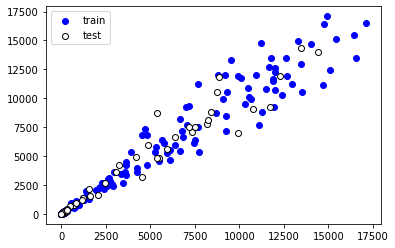

In [9]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

### Regresión Lineal

Probaremos ajustar los puntos usando una recta.

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [12]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [13]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.97786561]]
Mean squared error
Train error: 1177344.95
Test error: 1042548.57
Coefficient of determination
Train: 0.95
Test: 0.94


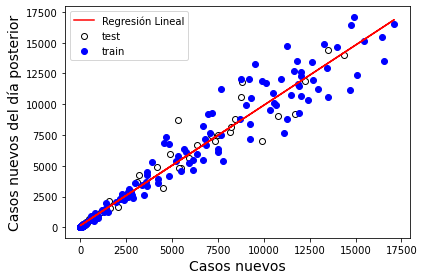

In [14]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_xlabel('Casos nuevos', fontsize=14)
ax.set_ylabel('Casos nuevos del día posterior', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='Regresión Lineal')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal.png')
plt.show()

La Regresión lineal de casos nuevos versus casos nuevos del día anterior es muy buena, como se podía esperar, pero tiene una dispersión muy grande y que crece en el tiempo. Además no da mucha información, en el sentido de que no es posible advertir un cambio de signo en la curva de casos nuevos solamente con la predicción de un día. Además el hecho de que dependa del dato del día anterior hace que esté sujeto a variaciónes propias de la dispersión de los datos y arrastradas por las irregularidades en la carga de datos.

### Regresión casos activos versus casos nuevos

In [15]:
df = df.dropna()

In [16]:
X, y = df['casos_activos'].to_numpy().reshape(-1,1), df['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((168, 1), (42, 1))

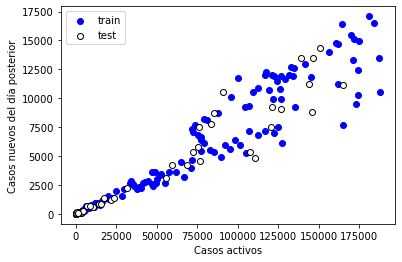

In [17]:
plt.ylabel('Casos nuevos del día posterior')
plt.xlabel('Casos activos')

plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

### Regresión Lineal

Probaremos ajustar los puntos usando una recta.

In [18]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [19]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [20]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.08065208]]
Mean squared error
Train error: 1922454.78
Test error: 1974228.74
Coefficient of determination
Train: 0.92
Test: 0.90


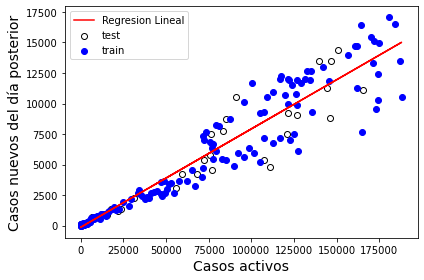

In [21]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_xlabel('Casos activos', fontsize=14)
ax.set_ylabel('Casos nuevos del día posterior', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='Regresion Lineal')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal_2.png')
plt.show()

Aquí propusimos ajustar casos nuevos con casos activos, debido a que se supone que los activos en un período determinado son los que pueden contaguiar y por lo tanto los contagiados nuevos deberían depender de los activos en tiempo anterior. Si bien sabemos que esto no es un modelo correcto ya que la dependencia es más compleja, puede ser un modelo que dé más información que el previo. Los datos siguen teniendo un buen ajuste lineal, si miramos los coeficientes determinación para Train y Test siguen siendo altos (>0.9), pero ahora se pueden distinguir dos regiones. Cuando los casos activos eran menos de 8000, se observa un régimen más lineal con poca dispersión de los datos, y a partir de que los casos activos superan los 8000, hay una gran dispersión de los datos que aunque puedan ser ajustados linealmente, claremente no se está reflejando su verdadera dependencia.

Acá es necesario remarcar que cuando fueron aumentando los casos, los sistemas de diagnósticos y de los reportes de casos nuevos han tenido cierto retraso, conbinado con un aumento del índice de positividad. Esa puede ser una de las causas de aumento abrupto en la dispersión de los datos.

#### Regresión promediando n días

In [22]:
n = 3

casos_t  = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
casos_t1 = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

len(casos_t),len(casos_t1)

(75, 75)

In [23]:
df3 = pd.DataFrame()

n = 3

df3['t']   = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
df3['t+1'] = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

In [24]:
df7 = pd.DataFrame()

n = 7

df7['t']   = [ df['t'][q:q+2].mean() for q in range(0,len(df['t'])-2*n+1,n) ]
df7['t+1'] = [ df['t'][q:q+2].mean() for q in range(n,len(df['t'])-n+1,n)   ]
df7['casos_activos']   = [ df['casos_activos'][q:q+2].mean() for q in range(0,len(df['casos_activos'])-2*n+1,n) ]

In [25]:
df5 = pd.DataFrame()

n = 5

df5['t']   = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
df5['t+1'] = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

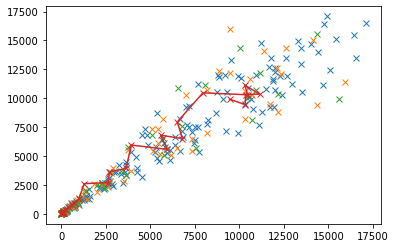

In [26]:
plt.plot(df['t'],df['t+1'],'x')
plt.plot(df3['t'],df3['t+1'],'x')
plt.plot(df5['t'],df5['t+1'],'x')
plt.plot(df7['t'],df7['t+1'],'x-')

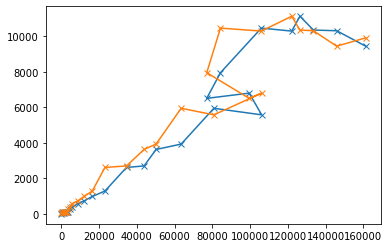

In [27]:
plt.plot(df7['casos_activos'],df7['t'],'x-')
plt.plot(df7['casos_activos'],df7['t+1'],'x-')

#### Promediando de a 3 días (n = 3)

In [28]:
X, y = df3['t'].to_numpy().reshape(-1,1), df3['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((52, 1), (23, 1))

In [29]:
# Create linear regression object
regr3 = linear_model.LinearRegression()

# Train the model using the training sets
regr3.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr3.predict(X_test)

# and training set
y_train_pred = regr3.predict(X_train)

In [30]:
# The coefficients
print('Coefficients: \n', regr3.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.94036448]]
Mean squared error
Train error: 2891337.28
Test error: 1516197.78
Coefficient of determination
Train: 0.87
Test: 0.93


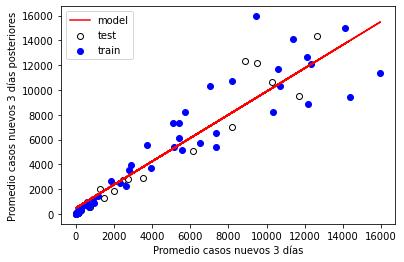

In [31]:
# Plot outputs

plt.ylabel('Promedio casos nuevos 3 días posteriores')
plt.xlabel('Promedio casos nuevos 3 días')

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

##### n = 5

In [32]:
X, y = df5['t'].to_numpy().reshape(-1,1), df5['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((35, 1), (9, 1))

In [33]:
# Create linear regression object
regr5 = linear_model.LinearRegression()

# Train the model using the training sets
regr5.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr5.predict(X_test)

# and training set
y_train_pred = regr5.predict(X_train)

In [34]:
# The coefficients
print('Coefficients: \n', regr5.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.9152149]]
Mean squared error
Train error: 2375373.88
Test error: 2365507.79
Coefficient of determination
Train: 0.89
Test: 0.87


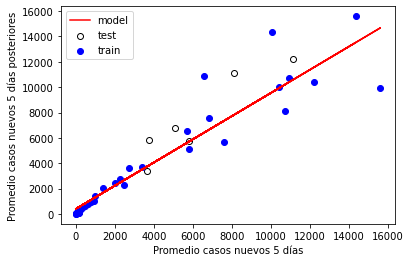

In [35]:
# Plot outputs
plt.ylabel('Promedio casos nuevos 5 días posteriores')
plt.xlabel('Promedio casos nuevos 5 días')

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.show()

##### n = 7

In [36]:
X, y = df7['t'].to_numpy().reshape(-1,1), df7['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((23, 1), (6, 1))

In [37]:
# Create linear regression object
regr7 = linear_model.LinearRegression()

# Train the model using the training sets
regr7.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr7.predict(X_test)

# and training set
y_train_pred = regr7.predict(X_train)

In [38]:
# The coefficients
print('Coefficients: \n', regr7.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[1.0470609]]
Mean squared error
Train error: 530077.55
Test error: 852513.88
Coefficient of determination
Train: 0.97
Test: 0.95


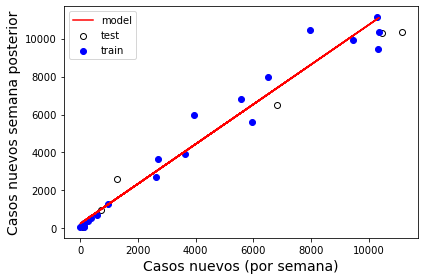

In [39]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_ylabel('Casos nuevos semana posterior', fontsize=14)
ax.set_xlabel('Casos nuevos (por semana)', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal_3.png')
plt.show()

In [40]:
n = 3

casos_t  = [ data['casos_nuevos'][q:q+2].mean() for q in range(0,len(data['casos_nuevos'])-2*n+1,n) ]
casos_t1 = [ data['casos_nuevos'][q:q+2].mean() for q in range(n,len(data['casos_nuevos'])-n+1,n)   ]

len(casos_t),len(casos_t1)

(75, 75)

### Casos activos versus casos nuevos

In [41]:
X, y = df7['casos_activos'].to_numpy().reshape(-1,1), df7['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((23, 1), (6, 1))

In [42]:
# Create linear regression object
regr7 = linear_model.LinearRegression()

# Train the model using the training sets
regr7.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr7.predict(X_test)

# and training set
y_train_pred = regr7.predict(X_train)

In [43]:
# The coefficients
print('Coefficients: \n', regr7.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.07348644]]
Mean squared error
Train error: 1507043.44
Test error: 1193003.15
Coefficient of determination
Train: 0.91
Test: 0.93


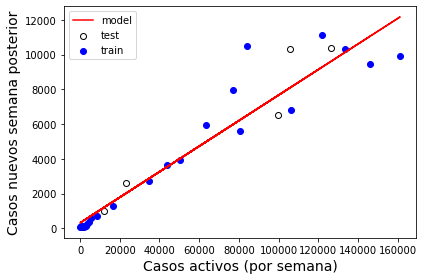

In [44]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_ylabel('Casos nuevos semana posterior', fontsize=14)
ax.set_xlabel('Casos activos (por semana)', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='model')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal_4.png')

plt.show()

### casos nuevos / casos activos

In [45]:
df_r = pd.DataFrame()
df_r.drop(df_r.tail(1).index,inplace=True)
df_r.dropna()

df_r['t_days']        = [ (pd.to_datetime(fecha) - pd.to_datetime(data['fecha'][0])).days for fecha in data['fecha'] ]
df_r['casos_activos'] = df['casos_activos']
df_r['diff']          = df['casos_activos+1'] - df['casos_activos']
df_r['activos/t']     = df['casos_activos']/df['t']
df_r = df_r.dropna()

In [46]:
def Ones(x):
    return np.ones(len(x))

def times(x):
    return np.arange(1,len(x)+1,1)

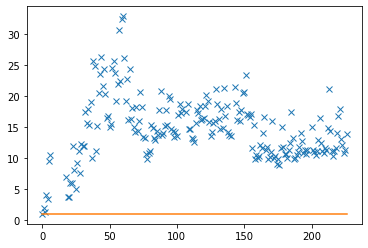

In [47]:
plt.plot(df_r['t_days'],df_r['activos/t'], 'x')
plt.plot(df_r['t_days'],Ones(df_r['t_days']))

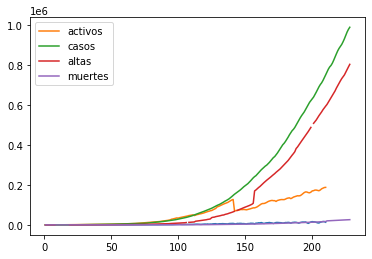

In [48]:
plt.plot(times(df['t']),df['t'])
plt.plot(times(df['casos_activos']),df['casos_activos'], label='activos')
plt.plot(times(data['casos_total']),data['casos_total'],label='casos')
plt.plot(times(data['alta_total']),data['alta_total'],label='altas')
plt.plot(times(data['muertes_total']),data['muertes_total'],label='muertes')
plt.legend()

### Regresión polinomial

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [50]:
df = pd.DataFrame()

df['casos_nuevos+7']   = data['casos_nuevos'].shift(-7)
df['casos_nuevos']   = data['casos_nuevos']
df['casos_activos']  = data['casos_total']-data['alta_total']
df['t_days']         = [ (pd.to_datetime(fecha) - pd.to_datetime(data['fecha'][0])).days for fecha in data['fecha'] ]
df['tests_nuevos']   = data['tests_realizados_nuevos']
df['tests_total']    = data['tests_realizados_total']
df['muertes_nuevos'] = data['muertes_nuevos']

df = df.dropna()
df.drop(df.tail(7).index,inplace=True)

In [51]:
select = df.keys()
select = select.drop('casos_nuevos+7')
select = select.drop('casos_nuevos')
select = select.drop('tests_nuevos')
select = select.drop('tests_total')
len(df[select].to_numpy().reshape(-1,1))

534

In [52]:
df[select]

,casos_activos,t_days,muertes_nuevos
33,1357.0,33,7
34,1430.0,34,5
35,1519.0,35,14
36,1535.0,36,3
37,1674.0,37,7
...,...,...,...
209,156356.0,209,419
210,161862.0,210,3352
211,165174.0,211,312
212,164704.0,212,197


In [53]:
y, X = df['casos_nuevos+7'].to_numpy().reshape(-1,1), df[select].to_numpy().reshape(-1,len(select))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 3), (54, 3), (124, 1), (54, 1))

In [54]:
train_errors = []
test_errors = []
degrees = range(1,10)
print( 'degree', '\t', 'train err', '\t', 'test err' )

for degree in degrees:
    # train:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # evaluate:
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    print( f'{degree} \t {train_error:0.2e} \t {test_error:0.2e}' )

degree 	 train err 	 test err
1 	 1.08e+06 	 3.70e+07
2 	 8.36e+05 	 1.88e+09
3 	 5.14e+05 	 1.11e+11
4 	 3.93e+05 	 1.06e+15
5 	 3.90e+05 	 1.48e+15
6 	 4.50e+05 	 3.20e+15
7 	 6.09e+05 	 1.71e+16
8 	 9.56e+05 	 1.42e+17
9 	 1.25e+06 	 5.05e+16


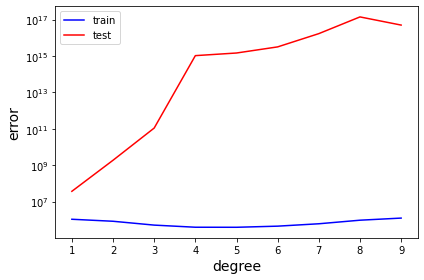

In [55]:
d = 9
fig, ax = plt.subplots()
plt.plot(degrees[:d], train_errors[:d], color="blue", label="train")
plt.plot(degrees[:d], test_errors[:d], color="red", label="test")
plt.legend()
plt.yscale('log')
ax.set_xlabel("degree", fontsize=14)
ax.set_ylabel("error", fontsize=14)
plt.tight_layout()
plt.savefig('regresion_polinomial.png')
plt.show()

In [56]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
    
# predict:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print( 'degree', '\t', 'train err', '\t', 'test err' )
print( f'{degree} \t {train_error:0.2e} \t {test_error:0.2e}' )

degree 	 train err 	 test err
3 	 1.25e+06 	 5.05e+16


In [57]:
model.get_feature_names()

AttributeError: 'Pipeline' object has no attribute 'get_feature_names'

### Experimentación con el dataset: Covid19Casos

##### Dataset - Covid19Casos
- Source: http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina/archivo/fd657d02-a33a-498b-a91b-2ef1a68b8d16

In [91]:
#url = 'https://sisa.msal.gov.ar/datos/descargas/covid-19/files/Covid19Casos.csv'

#df = pd.read_csv(url, error_bad_lines=False)
#df = pd.read_csv(url)

In [92]:
database = pd.read_csv('../Practico 1/casos_nuevos_por_dia.csv')
database

,Unnamed: 0,fecha,fecha_dias,casos_nuevos,casos_nuevos_mujeres,casos_nuevos_hombres,casos_totales,casos_totales_mujeres,casos_totales_hombres,muertes_nuevos,muertes_nuevos_mujeres,muertes_nuevos_hombres,muertes_totales,muertes_totales_mujeres,muertes_totales_hombres
0,0,2020-03-02,0.0,1,0,1,1,0,1,0,0,0,0,0,0
1,1,2020-03-03,1.0,2,0,2,3,0,3,0,0,0,0,0,0
2,2,2020-03-04,2.0,1,1,0,4,1,3,0,0,0,0,0,0
3,3,2020-03-05,3.0,5,1,4,9,2,7,0,0,0,0,0,0
4,4,2020-03-06,4.0,1,0,1,10,2,8,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,281,2020-12-08,281.0,2982,1519,1458,1475114,733467,738016,73,3,1,40524,1072,1250
282,282,2020-12-09,282.0,6369,3228,3126,1481483,736695,741142,51,2,3,40575,1074,1253
283,283,2020-12-10,283.0,6334,3167,3157,1487817,739862,744299,58,1,3,40633,1075,1256
284,284,2020-12-11,284.0,5419,2771,2626,1493236,742633,746925,26,0,0,40659,1075,1256


In [93]:
df1 = pd.DataFrame()

df1['t']   = database['casos_nuevos']
df1['t+1'] =  df1['t'].shift(-1)
df1['casos_totales']   = database['casos_totales']
df1['casos_totales+1'] = database['casos_totales'].shift(-1)

df1

,t,t+1,casos_totales,casos_totales+1
0,1,2.0,1,3.0
1,2,1.0,3,4.0
2,1,5.0,4,9.0
3,5,1.0,9,10.0
4,1,6.0,10,16.0
...,...,...,...,...
281,2982,6369.0,1475114,1481483.0
282,6369,6334.0,1481483,1487817.0
283,6334,5419.0,1487817,1493236.0
284,5419,1362.0,1493236,1494598.0


In [94]:
df1.drop(df1.tail(1).index,inplace=True)
df1.dropna()

,t,t+1,casos_totales,casos_totales+1
0,1,2.0,1,3.0
1,2,1.0,3,4.0
2,1,5.0,4,9.0
3,5,1.0,9,10.0
4,1,6.0,10,16.0
...,...,...,...,...
280,3289,2982.0,1472132,1475114.0
281,2982,6369.0,1475114,1481483.0
282,6369,6334.0,1481483,1487817.0
283,6334,5419.0,1487817,1493236.0


In [95]:
X, y = df1['t'].to_numpy().reshape(-1,1), df1['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((228, 1), (57, 1))

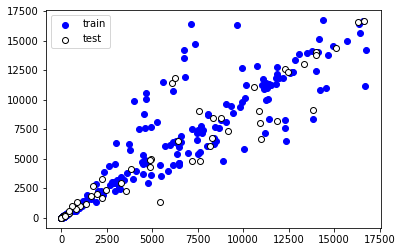

In [96]:
plt.scatter(X_train, y_train, color="blue", label="train")
plt.scatter(X_test, y_test, color="white", edgecolor="k", label="test")
plt.legend()
plt.show()

In [97]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [98]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [99]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.92972894]]
Mean squared error
Train error: 3686790.94
Test error: 2870772.57
Coefficient of determination
Train: 0.85
Test: 0.88


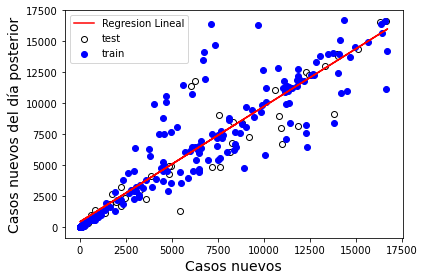

In [100]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_xlabel('Casos nuevos', fontsize=14)
ax.set_ylabel('Casos nuevos del día posterior', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='Regresion Lineal')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal_2.png')
plt.show()

In [68]:
df7 = pd.DataFrame()

df7['t']   = database['casos_nuevos']
df7['t+1'] =  df1['t'].shift(-7)
df7['casos_totales']   = database['casos_totales']
df7['casos_totales+1'] = database['casos_totales'].shift(-7)

df7

,t,t+1,casos_totales,casos_totales+1
0,1,4.0,1,22.0
1,2,8.0,3,30.0
2,1,11.0,4,41.0
3,5,19.0,9,60.0
4,1,32.0,10,92.0
...,...,...,...,...
281,2982,NaN,1475114,NaN
282,6369,NaN,1481483,NaN
283,6334,NaN,1487817,NaN
284,5419,NaN,1493236,NaN


In [69]:
df7 = df7.dropna()
df7

,t,t+1,casos_totales,casos_totales+1
0,1,4.0,1,22.0
1,2,8.0,3,30.0
2,1,11.0,4,41.0
3,5,19.0,9,60.0
4,1,32.0,10,92.0
...,...,...,...,...
273,7516,3289.0,1436550,1472132.0
274,7439,2982.0,1443989,1475114.0
275,6574,6369.0,1450563,1481483.0
276,6970,6334.0,1457533,1487817.0


In [70]:
X, y = df7['t'].to_numpy().reshape(-1,1), df7['t+1'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((222, 1), (56, 1))

In [71]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [72]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

# and training set
y_train_pred = regr.predict(X_train)

In [73]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print('Mean squared error')

print('Train error: %.2f' % train_error)
print('Test error: %.2f' % test_error)

# The coefficient of determination: 1 is perfect prediction

train_coeff = r2_score(y_train, y_train_pred)
test_coeff = r2_score(y_test, y_test_pred)

print('Coefficient of determination')

print('Train: %.2f' % train_coeff)
print('Test: %.2f' % test_coeff)

Coefficients: 
 [[0.95991554]]
Mean squared error
Train error: 1738748.49
Test error: 1193995.78
Coefficient of determination
Train: 0.93
Test: 0.95


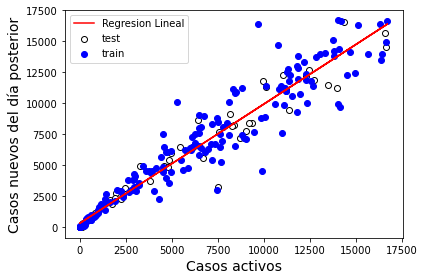

In [74]:
# Plot outputs
fig, ax = plt.subplots()
ax.set_xlabel('Casos activos', fontsize=14)
ax.set_ylabel('Casos nuevos del día posterior', fontsize=14)

plt.scatter(X_test, y_test,  color='white', edgecolor='k', label='test')
plt.scatter(X_train, y_train,  color='blue', label='train')
plt.plot(X_train, y_train_pred, color='red', label='Regresion Lineal')
plt.legend()
plt.tight_layout()
plt.savefig('regresion_lineal_2.png')
plt.show()

### Clasificación

In [75]:
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19-fallecidos.csv'

data = pd.read_csv(url, error_bad_lines=False)

In [76]:
data = data.drop(columns=['fecha', 'num_caso', 'tipo_caso', 'comorbilidades', 'viajes', 'observaciones'])

data = data.dropna()

data

,provincia,genero,edad
0,CABA,hombre,64.0
1,Chaco,hombre,61.0
2,CABA,hombre,64.0
3,Buenos Aires,mujer,67.0
5,Chaco,hombre,53.0
...,...,...,...
2277,Río Negro,hombre,87.0
2278,Buenos Aires,mujer,74.0
2279,Buenos Aires,mujer,61.0
2280,Buenos Aires,mujer,64.0


In [77]:
criteria = [data['edad'].between(0, 30), data['edad'].between(31, 60), data['edad'].between(61, 80), data['edad'].between(81, 100)]
values = ['0-30', '31-60', '61-80', '81-100']


In [78]:
data['rango-edad'] = np.select(criteria, values, 0)

In [79]:
data = data.drop(['edad'], axis=1)

### Tratamiento de género y rango-edad
Como se trata de **variables categóricas**, en la cuál no hay una relación de orden entre las categorías, necesitamos aplicar un **One Hot Encoding**

In [80]:
data = pd.concat([data, pd.get_dummies(data['genero'], prefix='genero')],axis=1).drop(['genero'], axis=1)

In [81]:
data = pd.concat([data, pd.get_dummies(data['rango-edad'], prefix='rango-edad')],axis=1).drop(['rango-edad'], axis=1)

In [82]:
data

,provincia,genero_hombre,genero_mujer,genero_sin dato,rango-edad_0,rango-edad_0-30,rango-edad_31-60,rango-edad_61-80,rango-edad_81-100
0,CABA,1,0,0,0,0,0,1,0
1,Chaco,1,0,0,0,0,0,1,0
2,CABA,1,0,0,0,0,0,1,0
3,Buenos Aires,0,1,0,0,0,0,1,0
5,Chaco,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2277,Río Negro,1,0,0,0,0,0,0,1
2278,Buenos Aires,0,1,0,0,0,0,1,0
2279,Buenos Aires,0,1,0,0,0,0,1,0
2280,Buenos Aires,0,1,0,0,0,0,1,0


### Selección de features y variable objetivo

**variable objetivo: 'provincia'**

In [83]:
feature_names = ['genero_hombre', 'genero_mujer']

X = data[feature_names]
y = data['provincia']

In [84]:
X.shape, y.shape

((2264, 2), (2264,))

### División en etrenamiento y evaluación

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1698, 2), (566, 2), (1698,), (566,))

### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.49
Accuracy of Logistic regression classifier on test set: 0.51


/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [88]:
from sklearn.metrics import classification_report

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

print(classification_report(y_test, y_test_pred))

                  precision    recall  f1-score   support

    Buenos Aires       0.51      1.00      0.67       288
            CABA       0.00      0.00      0.00       208
           Chaco       0.00      0.00      0.00        29
         Córdoba       0.00      0.00      0.00        10
        La Rioja       0.00      0.00      0.00         2
         Mendoza       0.00      0.00      0.00         4
        Misiones       0.00      0.00      0.00         1
         Neuquén       0.00      0.00      0.00         6
       Río Negro       0.00      0.00      0.00        12
           Salta       0.00      0.00      0.00         1
        Santa Fe       0.00      0.00      0.00         1
Tierra del Fuego       0.00      0.00      0.00         1
         Tucumán       0.00      0.00      0.00         3

        accuracy                           0.51       566
       macro avg       0.04      0.08      0.05       566
    weighted avg       0.26      0.51      0.34       566



/home/matias/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
data

,provincia,genero_hombre,genero_mujer,genero_sin dato,rango-edad_0,rango-edad_0-30,rango-edad_31-60,rango-edad_61-80,rango-edad_81-100
0,CABA,1,0,0,0,0,0,1,0
1,Chaco,1,0,0,0,0,0,1,0
2,CABA,1,0,0,0,0,0,1,0
3,Buenos Aires,0,1,0,0,0,0,1,0
5,Chaco,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2277,Río Negro,1,0,0,0,0,0,0,1
2278,Buenos Aires,0,1,0,0,0,0,1,0
2279,Buenos Aires,0,1,0,0,0,0,1,0
2280,Buenos Aires,0,1,0,0,0,0,1,0
